# NoteBook dedicated to creating a Multivariate Control Chart with Hotelling T2


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os
from scipy.stats import beta

Import the CSV file created in the Preprocessing Notebook

In [9]:
import csv 
filename = "Preprocessing/Preprocessing M1.csv"
data = pd.read_csv(filename)
del data["Unnamed: 0"]
data.head()

,Time,Dataset,Heat Zone,Max Temperature,Average Temperature,Sorted Heatmap,Average of Top 100 Temperature,Hourly Time
0,21-June-19 11:05:59,[50.15 50.3 50.45 ... 50.225 50.15 50.075],153427,207.5,81.657962,[ 50.006 50.006 50.006 ... 207.5 207.5 2...,203.44964,11:05:59
1,21-June-19 11:06:29,[50.2 50.4 50.6 ... 50.15 50.1 50.05],203807,206.1,76.343216,[ 50.006 50.006 50.006 ... 206.1 206.1 2...,203.79698,11:06:29
2,21-June-19 11:08:44,[51.85 53.7 55.55 ... 50.338 50.225 50.112],94795,179.4,73.001514,[ 50.006 50.006 50.006 ... 179.15 179.275 1...,176.38070,11:08:44
3,21-June-19 11:09:14,[50.425 50.85 51.275 ... 51.838 51.225 50.612],121499,217.9,84.590920,[ 50.006 50.006 50.006 ... 217.625 217.75 2...,214.24490,11:09:14
4,21-June-19 11:09:44,[50.475 50.95 51.425 ... 50.075 50.05 50.025],128739,193.3,84.295585,[ 50.006 50.006 50.006 ... 193.075 193.3 1...,191.43585,11:09:44


Created a new Dataframe to store the Multivariate Control Chart Variables

*UCL and T2 Columns will be filled in later*

In [3]:
df = pd.DataFrame(data[['Heat Zone','Max Temperature', 'Average Temperature']])
p = len(df.columns) #Number of Variables
df.insert(0,"Hourly Time", data["Hourly Time"])
df["UCL"] = np.nan
df["T2"] = np.nan
df.head()

,Hourly Time,Heat Zone,Max Temperature,Average Temperature,UCL,T2
0,11:05:59,153427,207.5,81.657962,NaN,NaN
1,11:06:29,203807,206.1,76.343216,NaN,NaN
2,11:08:44,94795,179.4,73.001514,NaN,NaN
3,11:09:14,121499,217.9,84.590920,NaN,NaN
4,11:09:44,128739,193.3,84.295585,NaN,NaN


## 1. Calculating T2 

Used Numpy to calculate the means of each the feature columnsn which consisted of Size of Heat Zone, Max Temperature, and Average Temperature

In [10]:
Heat_Zone_xbar = np.mean(df["Heat Zone"])
Max_Temp_xbar = np.mean(df["Max Temperature"])
Average_Temp_xbar = np.mean(df["Average Temperature"])
m = len(df.index)
print(f"Average of Heatzone Column: {Heat_Zone_xbar}")
print(f"Average of Max Temperature: {Max_Temp_xbar}")
print(f"Grand Mean of Average Temperature: {Average_Temp_xbar}")
print(f"Number of observations: {m}")

Average of Heatzone Column: 145112.35
Average of Max Temperature: 208.55600000000007
Grand Mean of Average Temperature: 82.20139476124946
Number of observations: 100


Formula of T2 for a dataset comprise of individual observations: 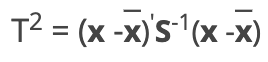

Construct a matrix using the the columns in our dataframe so we can perform mathematical operations readily using numpy

In [ ]:
arr = np.zeros(shape=(p,m))#Generalize to all dimensions

arr[0] = df["Heat Zone"]
arr[1] = df["Max Temperature"]
arr[2] = df["Average Temperature"]

Calculate the Covariance Matrix of our data then take the inverse 

In [ ]:
S = np.cov(arr)
#print(f"Covariance Matrix: \n", S)
inverse_S = np.linalg.inv(S)
#print(f"Inverse S: \n", inverse_S)

Subtracting the means of each column from the data

In [ ]:
arr[0] = arr[0] - Heat_Zone_xbar
arr[1] = arr[1] - Max_Temp_xbar
arr[2] = arr[2] - Average_Temp_xbar

Calculate the T2 for each row of our dataset

In [ ]:
T2_col = []
for i in range(m):
    vec = np.array([[arr[0][i]],[arr[1][i]],[arr[2][i]]]) # (3,1)
    vec_trans = vec.reshape(1,3) #(1,3)
    T2 = np.matmul(np.matmul(vec_trans, inverse_S),vec) #One Indicates Individual Observation
    #print(f"{i}: ",T2)
    T2_col.append(T2[0][0])
    

M = number of samples (100)

p = number of variables (3)

b = beta distribution

a = confidence interval 

In a Multivariate Control Chart there is only a UCL (as the x-axis serve as the LCL)

The Cells below are the steps taken to calculate the UCL

Formula: 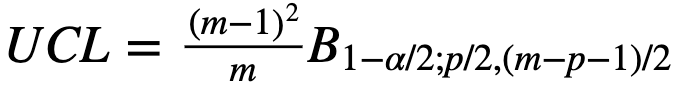

*UCL does not depend on T2*

In [ ]:

a = 0.05
b = beta.ppf(1-a/2, (p/2),(m-p-1)/2)
#print(f"Beta: {b}")

ucl = (((m-1)**2)/m) * b
#print(f"UCL: {ucl}")

Add more columns to our dataframe

In [ ]:
df.loc[:, "UCL"] = ucl
df.loc[:, "T2"] = T2_col
df

## 2. Plotting the Multivariate Control Chart 

Consist of T2 and UCL

*No LCL*

In [ ]:
#Rerun if Plot size does not adjust 
plt.title("Multivariate Control Chart")
plt.plot(data["Hourly Time"], df["T2"], "b-", label = "T2")
plt.plot(data["Hourly Time"], df["UCL"], "r-", label = "UCL")
plt.legend(loc="best")
plt.xticks(rotation = 90)
plt.xlabel("Hourly Time")
plt.ylabel("T-Square")
plt.figure(figsize=(20,10))
plt.rcParams["figure.figsize"] = [22,9]
plt.show()

Indexing and dropping the observations that are abnormal (*T2 > UCL*)

## 3. Remove Abnormal Observations from Dataframe

Rows that are considered abnormal are those who have T2 values which are greater than the UCL

In [ ]:
#I have improved my code for finding out of bounds since the Univariate Control Chart
out_of_bounds = df[df["T2"] > df["UCL"]].index
print("Number of Abnormal Observations:", len(out_of_bounds))
print(df.loc[out_of_bounds, "Hourly Time"])

In [ ]:
df.drop(out_of_bounds, inplace = True)
df

In [ ]:
df

## Repeat...

In [ ]:
'''Can further be generalize to p by m size dataframes'''
def calculations():
    
    Heat_Zone_xbar = np.mean(df["Heat Zone"])
    Max_Temp_xbar = np.mean(df["Max Temperature"])
    Average_Temp_xbar = np.mean(df["Average Temperature"])
    m = len(df.index)
    print(f"Average of Heatzone Column: {Heat_Zone_xbar}")
    print(f"Average of Max Temperature: {Max_Temp_xbar}")
    print(f"Grand Mean of Average Temperature: {Average_Temp_xbar}")
    print(f"Number of observations: {m}")
    
    arr = np.zeros(shape=(p,m))#Generalize to all dimensions

    arr[0] = df["Heat Zone"]
    arr[1] = df["Max Temperature"]
    arr[2] = df["Average Temperature"]
    
    
    S = np.cov(arr)
    inverse_S = np.linalg.inv(S)
    
    arr[0] = arr[0] - Heat_Zone_xbar
    arr[1] = arr[1] - Max_Temp_xbar
    arr[2] = arr[2] - Average_Temp_xbar
    
    T2_col = []
    for i in range(m):
        vec = np.array([[arr[0][i]],[arr[1][i]],[arr[2][i]]]) # (3,1)
        vec_trans = vec.reshape(1,3) #(1,3)
        T2 = np.matmul(np.matmul(vec_trans, inverse_S),vec) #One Indicates Individual Observation
        #print(f"{i}: ",T2)
        T2_col.append(T2[0][0])
    
    a = 0.05
    b = beta.ppf(1-a/2, (p/2),(m-p-1)/2)
    ucl = (((m-1)**2)/m) * b
    
    df.loc[:, "UCL"] = ucl
    df.loc[:, "T2"] = T2_col
    df
    
def plot_control_chart():
    plt.title("Multivariate Control Chart")
    plt.plot(df["Hourly Time"], df["T2"], "b-", label = "T2")
    plt.plot(df["Hourly Time"], df["UCL"], "r-", label = "UCL")
    plt.legend(loc="best")
    plt.xticks(rotation = 90)
    plt.xlabel("Hourly Time")
    plt.ylabel("T-Square")
    plt.figure(figsize=(20,10))
    plt.rcParams["figure.figsize"] = [22,9]
    plt.show()
    
def out_of_control():
    out_of_bounds = df[df["T2"] > df["UCL"]].index
    print("Number of Abnormal Observations:", len(out_of_bounds))
    print(df.loc[out_of_bounds, "Hourly Time"])
    df.drop(out_of_bounds, inplace = True)
    df


## Iteration 2

After dropping all the abnormal observations now we have a *normal* dataset that can be used to model future observations.

**Assuming we don't need to recalculate UCL or T2 on the second round of iteration but I'll have to confirm that with the professor**

In [ ]:
plot_control_chart()

out_of_control()


There are no more outliers so now we can use this dataset as a way to model future observations.

# This concludes this Notebook.

In the next notebook we will examine **T2 Decomposition** which will allows us to see which of the 3 variables caused the observation to be consider out of control.